# Image Classification

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


## Data Path Preparation

In [5]:
main_dir = 'Dataset'

In [10]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\cardboard
Memproses subdir: Dataset\e-waste
Memproses subdir: Dataset\glass
Memproses subdir: Dataset\medical
Memproses subdir: Dataset\metal
Memproses subdir: Dataset\paper
Memproses subdir: Dataset\plastic


In [11]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [15]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                             file_paths     labels
0     Dataset\cardboard\cardboard 1.jpg  cardboard
1    Dataset\cardboard\cardboard 10.jpg  cardboard
2   Dataset\cardboard\cardboard 100.jpg  cardboard
3  Dataset\cardboard\cardboard 1000.jpg  cardboard
4  Dataset\cardboard\cardboard 1001.jpg  cardboard
labels
e-waste      2406
paper        2156
plastic      2126
metal        2068
glass        2022
cardboard    1931
medical      1565
Name: count, dtype: int64


## Data Split

In [16]:
train_size = 0.8 
test_size = 0.2

In [17]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 11419 test_set length: 2855


## Preprocessing

In [18]:
# Standarisasi
height = 150
width = 150
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [19]:
datagen = ImageDataGenerator(
    rescale= 1./255.,
    rotation_range= 30,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [20]:
# Train Data
train_gen = datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 11419 validated image filenames belonging to 7 classes.


In [21]:
# Test Data
test_gen = datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2855 validated image filenames belonging to 7 classes.


In [22]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


## Data Checking

In [23]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

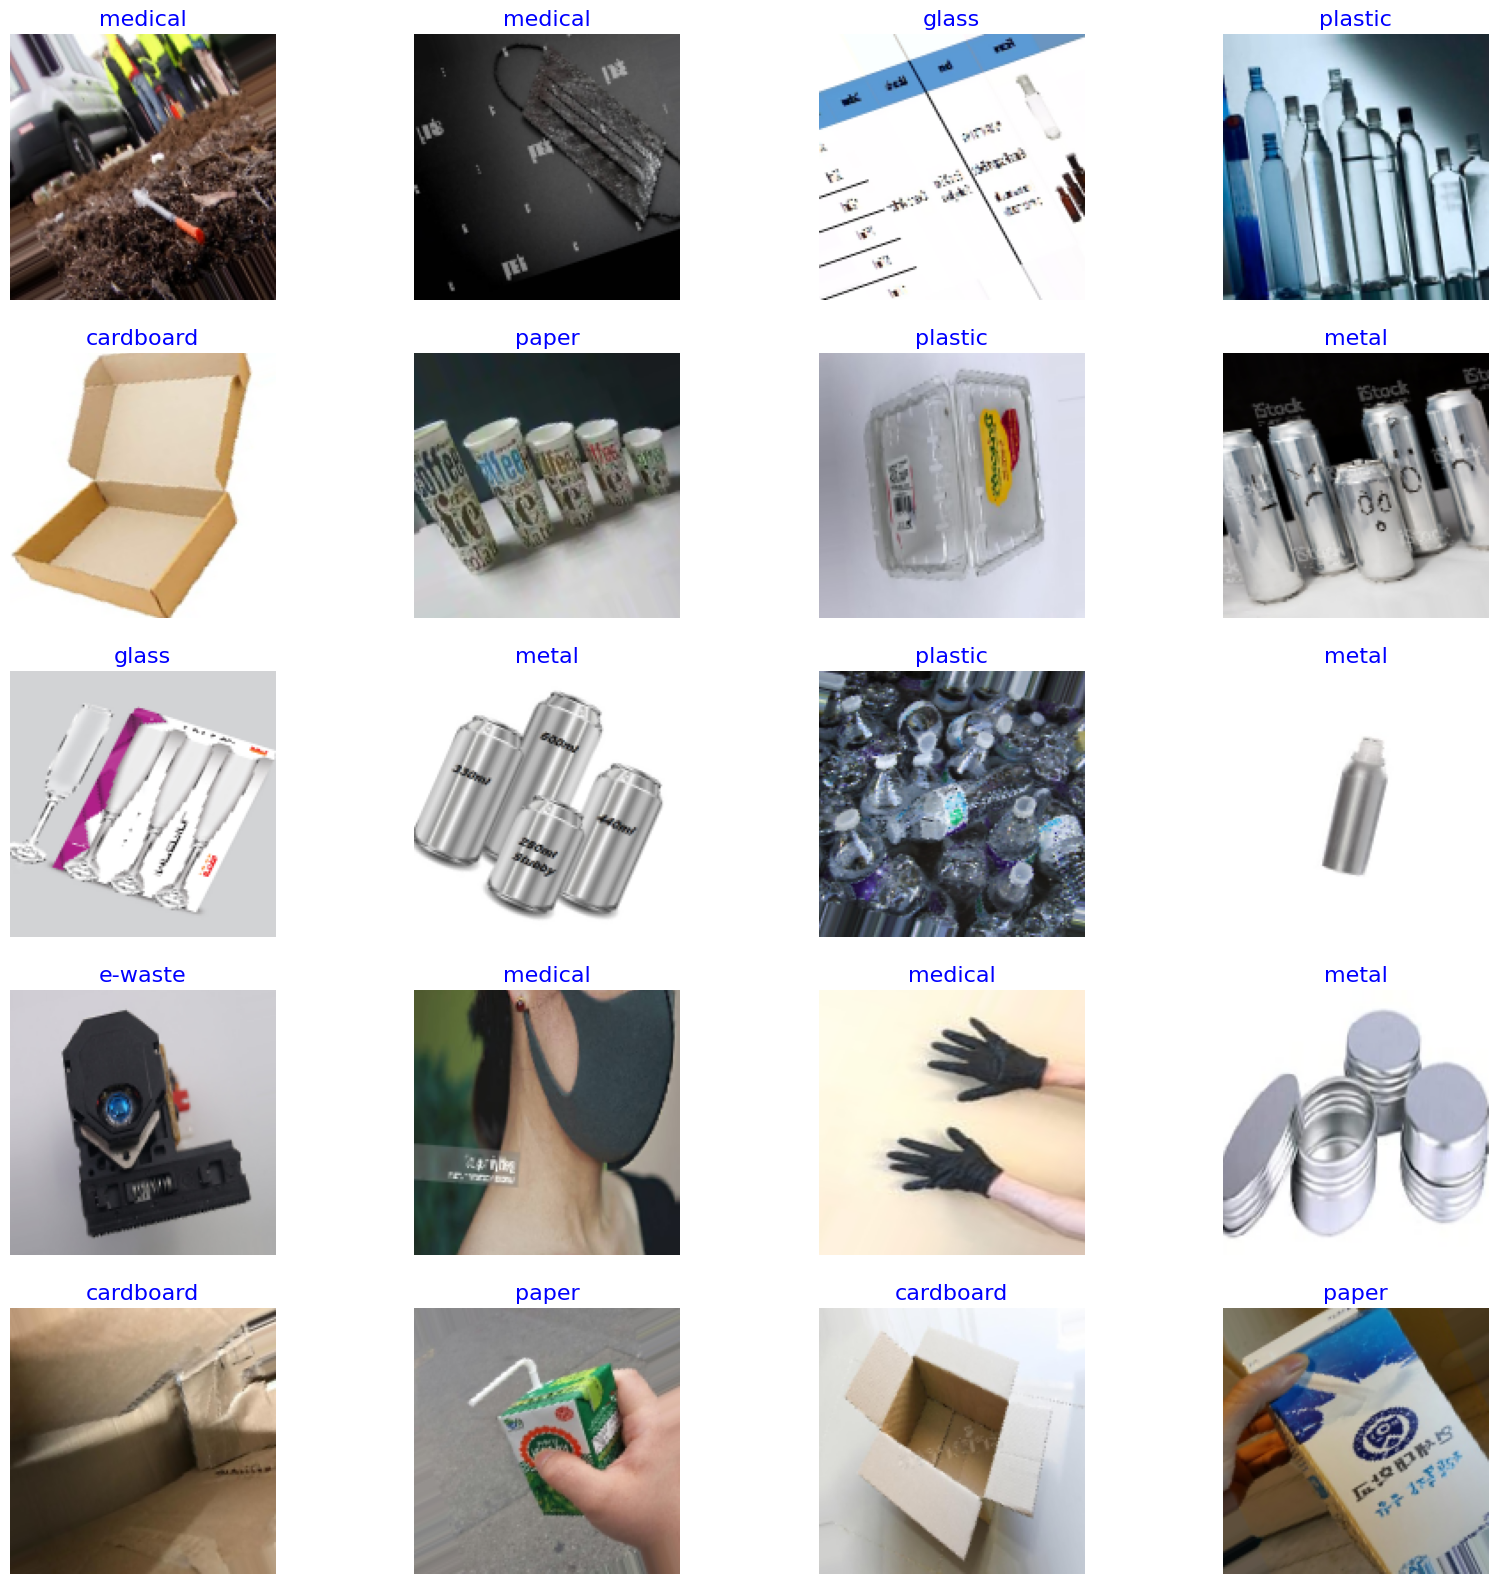

In [24]:
show_samples(train_gen)

## Model

### Design

In [ ]:
# Definisiin extractor dan compile model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

# Build the model
model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Call build() method to build the model
model.build((None, 224, 224, 3))

# Print model summary
model.summary()

### Training

In [ ]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Save Model

### TF-Lite

### TFJS

### TF-Serving